### importing and parsing

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M')

df_york = pd.read_csv("df_york_model.csv", parse_dates=['post_timing'], date_parser=dateparse, index_col = 0)
df_philly = pd.read_csv("df_philly_model.csv", parse_dates=['post_timing'], date_parser=dateparse, index_col = 0)

In [3]:
df_york['post_timing'].max()

Timestamp('2021-02-18 16:47:00')

In [4]:
df_philly['post_timing'].max()

Timestamp('2021-02-18 17:22:00')

In [5]:
df_york['post_timing_days'] = (df_york['post_timing'].max() - df_york['post_timing']).dt.days
df_york = df_york.drop(columns = ['post_timing'])
df_philly['post_timing_days'] = (df_philly['post_timing'].max() - df_philly['post_timing']).dt.days
df_philly = df_philly.drop(columns = ['post_timing'])

<AxesSubplot:>

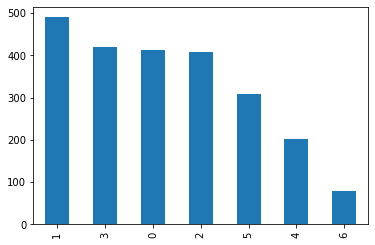

In [6]:
(df_york['post_timing_days'].astype(str)).value_counts(ascending = False)[:15].plot(kind='bar')

<AxesSubplot:xlabel='post_timing_days'>

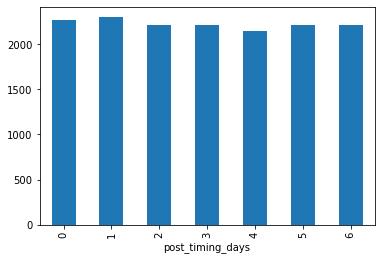

In [7]:
#The average for different housing types for number of days old in Craiglist looks same.
df_york.groupby(['post_timing_days'])['post_prices'].mean().plot(kind = 'bar')

<AxesSubplot:xlabel='post_timing_days'>

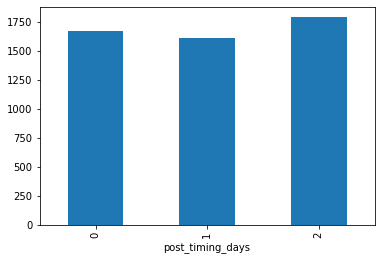

In [8]:
df_philly.groupby(['post_timing_days'])['post_prices'].mean().plot(kind = 'bar')

In [9]:
#Compare to Newyork , Philly has listing post just 2 days old.

### Change float to integer
There are number of features like sqfts, price , bedroom and bathroom count in float

In [10]:
df_york.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2321
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   post_prices       2321 non-null   float64
 1   sqfts             2321 non-null   float64
 2   bedroom_counts    2321 non-null   float64
 3   No_of_bathrooms   2321 non-null   float64
 4   pet               2321 non-null   object 
 5   laundry           2321 non-null   object 
 6   parking           2321 non-null   object 
 7   Apartment_type    2321 non-null   object 
 8   postcode          2321 non-null   object 
 9   pickup cluster    2321 non-null   int64  
 10  post_timing_days  2321 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 217.6+ KB


In [11]:
columns = df_york.select_dtypes(include=['float']).columns

In [12]:
def change_float(df):
    '''Change the float columns into integer in pandas DataFrame'''
    for col in df.select_dtypes(include=['float']).columns:
        df[col]= df[col].astype(int)
    return df
change_float(df_york)
change_float(df_philly)

,post_prices,sqfts,bedroom_counts,No_of_bathrooms,pet,laundry,parking,Apartment_type,postcode,pickup cluster,post_timing_days
0,3045,1002,2,2,both pets,in unit,no,multi,19123,10,0
1,1000,859,1,1,no pet,in unit,off-street,multi,19148,0,0
2,2487,859,1,1,no pet,in unit,no,multi,19104,7,0
3,1690,1100,1,1,no pet,in unit,no,multi,19106,0,0
4,1100,859,1,1,both pets,no laundry,no,multi,19130,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1809,1000,859,1,1,both pets,on site,no,multi,19125,10,2
1810,1300,859,1,1,both pets,in unit,no,multi,19147,0,2
1811,2177,780,1,1,both pets,in unit,protected,multi,19107,0,2
1812,5895,1610,5,2,both pets,in unit,no,multi,19104,7,2


In [13]:
df_york.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2321
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   post_prices       2321 non-null   int64 
 1   sqfts             2321 non-null   int64 
 2   bedroom_counts    2321 non-null   int64 
 3   No_of_bathrooms   2321 non-null   int64 
 4   pet               2321 non-null   object
 5   laundry           2321 non-null   object
 6   parking           2321 non-null   object
 7   Apartment_type    2321 non-null   object
 8   postcode          2321 non-null   object
 9   pickup cluster    2321 non-null   int64 
 10  post_timing_days  2321 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 217.6+ KB


In [14]:
df_philly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1808 entries, 0 to 1813
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   post_prices       1808 non-null   int64 
 1   sqfts             1808 non-null   int64 
 2   bedroom_counts    1808 non-null   int64 
 3   No_of_bathrooms   1808 non-null   int64 
 4   pet               1808 non-null   object
 5   laundry           1808 non-null   object
 6   parking           1808 non-null   object
 7   Apartment_type    1808 non-null   object
 8   postcode          1808 non-null   object
 9   pickup cluster    1808 non-null   int64 
 10  post_timing_days  1808 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 169.5+ KB


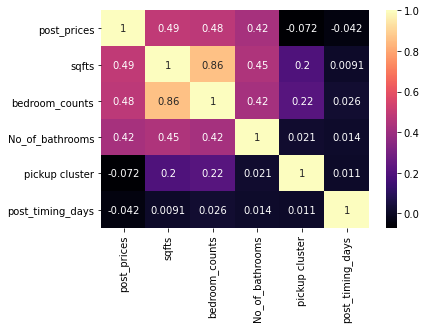

In [15]:
sns.heatmap(df_york.corr(), annot = True, cmap = 'magma')

plt.savefig('york_heatmap.png')
plt.show()

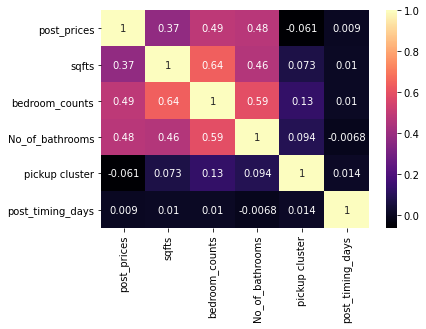

In [16]:
sns.heatmap(df_philly.corr(), annot = True, cmap = 'magma')

plt.savefig('philly_heatmap.png', dpi=300, bbox_inches = "tight")
plt.show()

Post_timing_days is not correlated with post_prices or any other features.
Bedroom Count is correlated with sqfts and post prices and bathroom counts.

#### Stack vertically both philadelphia and York to train the model

In [17]:
df = pd.concat([df_york, df_philly])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4129 entries, 0 to 1813
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   post_prices       4129 non-null   int64 
 1   sqfts             4129 non-null   int64 
 2   bedroom_counts    4129 non-null   int64 
 3   No_of_bathrooms   4129 non-null   int64 
 4   pet               4129 non-null   object
 5   laundry           4129 non-null   object
 6   parking           4129 non-null   object
 7   Apartment_type    4129 non-null   object
 8   postcode          4129 non-null   object
 9   pickup cluster    4129 non-null   int64 
 10  post_timing_days  4129 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 387.1+ KB


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


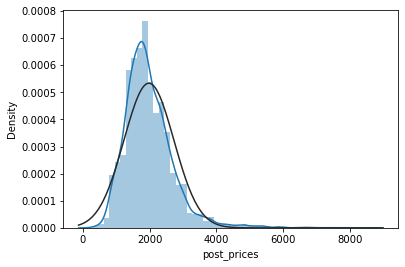

In [19]:
sns.distplot(df['post_prices'], fit = norm)
(mu, sigma) = norm.fit(df['post_prices'])

In [20]:
def ecdf(df):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(df)

    x = np.sort(df)

    y = np.arange(1, n+1) / n

    return x, y

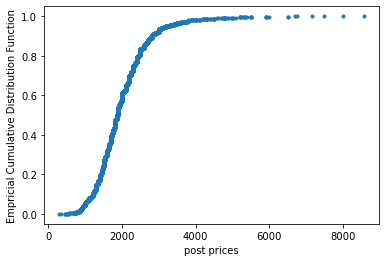

In [21]:
x_vers, y_vers = ecdf(df['post_prices'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('post prices')
plt.ylabel('Empricial Cumulative Distribution Function')
plt.savefig("empirical_cdf_price.png")

# Display the plot
plt.show()

We have 70% data having listing price less than $2800

### Label Encoding

In [22]:
non_num = df.select_dtypes(include=['object']).columns
for c in non_num:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

### Linear_Regression_Model

In [23]:
X_df = df[['sqfts', 'bedroom_counts', 'No_of_bathrooms', 'pickup cluster', 'post_timing_days','pet', 'laundry', 'parking', 'Apartment_type', 'postcode']]

In [24]:
y_df= df[['post_prices']]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.3, random_state = 42)

In [28]:
len(np.array(ols_pred))

NameError: name 'ols_pred' is not defined

In [29]:
 from sklearn.metrics import f1_score

In [30]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_pred = ols.predict(X_test)

In [31]:
#mean square error
np.sqrt(mean_squared_error(y_test, ols_pred))

575.5341866867524

In [32]:
#explained_variance_score
evs(y_test, ols_pred)

0.4252295470880457

In [33]:
#r-squared error
r2(y_test, ols_pred)

0.4252113368622287

In [34]:
print(ols.score(X_train, y_train))

0.43304192341813785


### Bayesian_model

In [35]:
from sklearn.linear_model import BayesianRidge
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_pred = bayesian.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [36]:
#explained_variance_score
evs(y_test, bayesian_pred)

0.42474307647951703

In [37]:
r2(y_test, bayesian_pred)

0.4247248429103143

In [38]:
#mean square error
np.sqrt(mean_squared_error(y_test, bayesian_pred))

575.7776976483623

### XGB_regressor

In [39]:
xgb_m = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123)

In [40]:
xgb_m.fit(X_train, y_train) 
xgb_pred = xgb_m.predict(X_test)

[21:41:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [41]:
evs(y_test, xgb_pred)

0.5917778588984596

In [42]:
r2(y_test, xgb_pred)

0.5852783701344253

In [43]:
np.sqrt(mean_squared_error(y_test, xgb_pred))

488.8722345482705

In [44]:
mean_absolute_error(y_test, xgb_pred)

314.66512891570824

In [45]:
xgb_prd = xgb_m.predict(X_train)

In [46]:
r2(y_train, xgb_prd)

0.7403759371615866

In [47]:
print(xgb_m.score(X_train, y_train))

0.7403759371615866


### RandomForest_Regressor

In [48]:
rf_reg = RandomForestRegressor(random_state = 42)

In [49]:
rf_reg.fit(X_train, y_train) 
#rf_pred = rf_reg.predict(X_test)

<ipython-input-49-5bd3804456c0>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [50]:
rf_pred = rf_reg.predict(X_test)
len(rf_pred)

1239

In [51]:
print(rf_reg.score(X_test, y_test))

0.5961699894021193


In [52]:
print(r2(y_test,rf_pred))

0.5961699894021193


In [53]:
np.sqrt(mean_squared_error(y_test, rf_pred))

482.4100247556307

In [54]:
evs(y_test, rf_pred)

0.5963311035665146

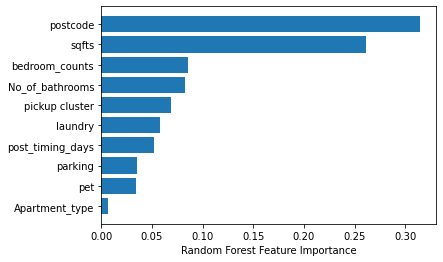

In [55]:
sorted_idx = rf_reg.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf_reg.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig("Random Forest Feature Importance.jpeg", dpi=300, bbox_inches = "tight")

In [ ]:
The best performance features for the Ranom Forest Model

Overfitting Model

In [57]:
print(rf_reg.score(X_train, y_train))

0.9338042223879803


In [598]:
rf_reg.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

### Use K folds Cross Validation

#### cross val with xgboostregressor

In [ ]:
cv_r2_scores_xgb = cross_val_score(xgb_m, X_df, y_df, cv=5,scoring='r2')

In [ ]:
print(cv_r2_scores_xgb)
print(np.mean(cv_r2_scores_xgb))

#### cross val with randomforestregressor

In [ ]:
cv_r2_scores_rf = cross_val_score(rf_reg, X_df, y_df, cv=5,scoring='r2')

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
print(cv_r2_scores_rf)
print(cv_r2_scores_rf.mean())

In [ ]:
predicted = cross_val_predict(rf_reg, X_df, y_df, cv=5)
fig, ax = plt.subplots()
ax.scatter(y_df, predicted)
ax.plot([y_df.min(), y_df.max()], [y_df.min(), y_df.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.savefig("Actual vs Predicted Values.png")
plt.show()

### Manually perform the training repeatedly on each k-1 folds (x_train, y_train) and 
use the Kth fold (x_test, y_test) for testing 

#### RandomForestRegressor

In [ ]:
scores = []
for i in range(5):
    kf = KFold(n_splits=5)
    result = next(kf.split(X_df), None)
    X_train = X_df.iloc[result[0]]
    X_test = X_df.iloc[result[1]]
    y_train = y_df.iloc[result[0]]
    y_test = y_df.iloc[result[1]]
    rf_reg.fit(X_train,y_train)
    predictions = rf_reg.predict(X_test)
    scores.append(r2(y_test, predictions))
print('Scores from each Iteration: ', scores)
print('Average K-Fold Score :' , np.mean(scores))

In [ ]:
np.sqrt(mean_squared_error(y_test, predictions))

In [ ]:
np.sqrt(mean_squared_error(y_train, ))

#### XGBooostRegressor

In [ ]:
scores = []
for i in range(5):
    result = next(kf.split(X_df), None)
    X_train = X_df.iloc[result[0]]
    X_test = X_df.iloc[result[1]]
    y_train = y_df.iloc[result[0]]
    y_test = y_df.iloc[result[1]]
    model = xgb_m.fit(X_train,y_train)
    predictions = xgb_m.predict(X_test)
    scores.append(model.score(X_test,y_test))
print('Scores from each performance: ', scores)
print('Average score :' , np.mean(scores))

# HyperParameter Tuning Using GridSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestRegressor()

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_df, y_df)

In [ ]:
rf_random.best_params_

In [ ]:
rf_reg = RandomForestRegressor(random_state = 42, bootstrap= True, max_features= 'auto', min_samples_leaf= 2, 
                               n_estimators = 180,max_depth = None, min_samples_split = 2)

In [ ]:
cv_r2_scores_rf = cross_val_score(rf_reg, X_df, y_df, cv=5, scoring='r2')

In [ ]:
print(cv_r2_scores_rf)
print(cv_r2_scores_rf.mean())

In [ ]:
{'n_estimators': 180,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [ ]:
def Grid_Search_CV_RFR(X_df, y_df):

    estimator = RandomForestRegressor(random_state = 42)
    param_grid = {"n_estimators" : [160,180,190],
            "max_features": ["auto"],
            "min_samples_split" : [1,2,3],
            "bootstrap": [True],
            "min_samples_leaf" : [1,2,3]}
    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, verbose = 2)

    grid.fit(X_df, y_df)

    return grid.best_score_ , grid.best_params_

In [ ]:
Grid_Search_CV_RFR(X_df, y_df)

In [ ]:
#Using the best params from the GridSearch
rf_reg = RandomForestRegressor(bootstrap= True, max_features= 'auto', min_samples_split= 2, n_estimators=180, random_state =42, min_samples_leaf = 3)

In [ ]:
cv_r2_scores_rf = cross_val_score(rf_reg, X_df, y_df, cv=5, scoring='r2')

In [ ]:
print(cv_r2_scores_rf)
print(cv_r2_scores_rf.mean())

#### Our data is limited for the better prediction. On comparing the different model, RandomForestClassifer shows better performance.

In [ ]:
sorted_idx = feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf_reg.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig("Random Forest Feature Importance.jpeg", dpi=300, bbox_inches = "tight")